<a href="https://colab.research.google.com/github/knarfamlap/adversarial_examples/blob/main/adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
def normalize_img(image, label):
  """Normalize images to float32"""
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [ ]:
model.fit(x_train, y_train, epochs=6,)

Epoch 1/6
1875/1875 [==============================] - 4s 2ms/step - loss: 27.3046 - accuracy: 0.0992
Epoch 2/6
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.1019
Epoch 3/6
1875/1875 [==============================] - 4s 2ms/step - loss: 27.3046 - accuracy: 0.1021
Epoch 4/6
1875/1875 [==============================] - 4s 2ms/step - loss: 27.3046 - accuracy: 0.1004
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - loss: 27.3046 - accuracy: 0.0999
Epoch 6/6
1875/1875 [==============================] - 4s 2ms/step - loss: 27.3046 - accuracy: 0.1013


In [ ]:
def adversarial_example(image, label):
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)

  gradient = tape.gradient(loss, image)
  signed_grad = tf.sign(gradient)

  return signed_grad

In [ ]:
model(x_test[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.09999911, 0.10000004, 0.10000168, 0.09999675, 0.10000031,
        0.10000307, 0.10000127, 0.09999841, 0.09999909, 0.10000024]],
      dtype=float32)>

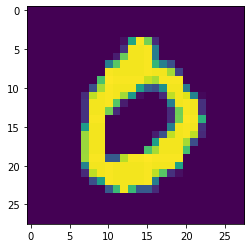

In [ ]:
plt.imshow(x_test[3])

In [ ]:
y_test[3]

0

In [ ]:
image = x_test[3]
label = y_test[3]

In [ ]:
perturbations = adversarial_example(tf.convert_to_tensor(image.reshape(img_rows, img_cols, channels)), label).numpy()

InvalidArgumentError: ignored

In [ ]:
adversarial = image + perturbations * 0.1

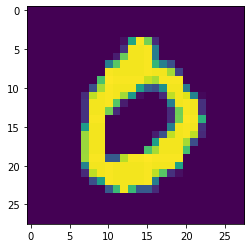

In [ ]:
plt.imshow(adversarial.reshape((img_rows, img_cols)))

In [ ]:
x_train[0].reshape((img_rows, img_cols, channels)).shape

(28, 28, 1)

In [ ]:
adversarial_example(x_train[0].reshape((img_rows, img_cols, channels)), y_train[0])

ValueError: ignored

In [ ]:
tf.convert_to_tensor(x_train[0].reshape((img_rows, img_cols, channels)))

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],